# Avian Classification using Computer Vision

### Introduction
The dataset in question provides audio files of bird callings from a Global Biodiversity region of Western Ghats. This is an important task for scientists who monitor bird populations for conservation purposes. More accurate solutions could enable more comprehensive monitoring.

Birds serve as valuable indicators of biodiversity change due to their mobility and diverse habitat needs. Variations in bird species composition and population numbers can provide insights into the success or shortcomings of restoration efforts. However, traditional observer-based bird biodiversity surveys are often costly and logistically demanding, particularly over extensive areas. In contrast, passive acoustic monitoring (PAM), coupled with advanced machine learning analytical tools, enables conservationists to survey larger spatial areas with higher temporal resolution, offering deeper insights into the connections between restoration interventions and biodiversity.

### Team Members:

1. Suman Senapati
2. Koelgeet Kaur
3. Dr. Sanjay Kumar

# Import Libraries

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch"

from sklearn.model_selection import train_test_split

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np
import pandas as pd

import seaborn as sns

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

/tmp/ipykernel_23/3768734162.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


# Library Version

In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


# Configuration

A class titled 'CFG' is defined here setting various critical parameters within the notebook. The parameters of this class will serve as the preset parameters of various methods later on

In [ ]:
class CFG:
    seed = 42 # Seed will be used for random state

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # Short-time Fourier Transform parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, pretrained model name
    epochs = 8
    preset = 'efficientnetv2_b2_imagenet'

    # Data augmentation parameters
    augment=True

    # Class Labels
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Reproducibility

This sets the random seed value to CFG.seed parameter value to ensure reproducibility

In [ ]:
tf.keras.utils.set_random_seed(CFG.seed)

# Dataset Path

Base path of the dataset

In [ ]:
BASE_PATH = '/kaggle/input/birdclef-2024'

# Meta Data

The metadata associated to the sound files are loaded in a dataframe 'df'.

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display two rows of data for understanding metadata
df.head(2)

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   

      scientific_name             common_name            author  \
0  Muscicapa dauurica  Asian Brown Flycatcher    Matt Slaymaker   
1  Muscicapa dauurica  Asian Brown Flycatcher  Magnus Hellström   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   

                                 url      filename  \
0  https://www.xeno-canto.org/134896  XC134896.ogg   
1  https://www.xeno-canto.org/164848  XC164848.ogg   

                                            filepath  target     xc_id  
0  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC134896  
1  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC164848

# Data Loader Functions

## Decoders

In [ ]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes)  # For decoding .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1] > 1:  # Conversion of stereo to mono
            audio = audio[..., 0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        print(audio_len)
        diff_len = abs(target_len - audio_len) # finds difference between target and audio length
        if audio_len < target_len:  # Adds padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # crops if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardization
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalization using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Loading audio file
        audio = get_audio(path)
        # Cropping or padding audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Applying normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


## Augmenters

In [ ]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment

# Exploratory Data Analysis

The dataset consists of two segments: the audio files and its associated metadata. The Exploratory Data Analysis has to be done separately on these two segments to analyse and comprehend the data

## Visualizing Audio Data

In [ ]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

### Sample 1

# Audio:


# Visualization:


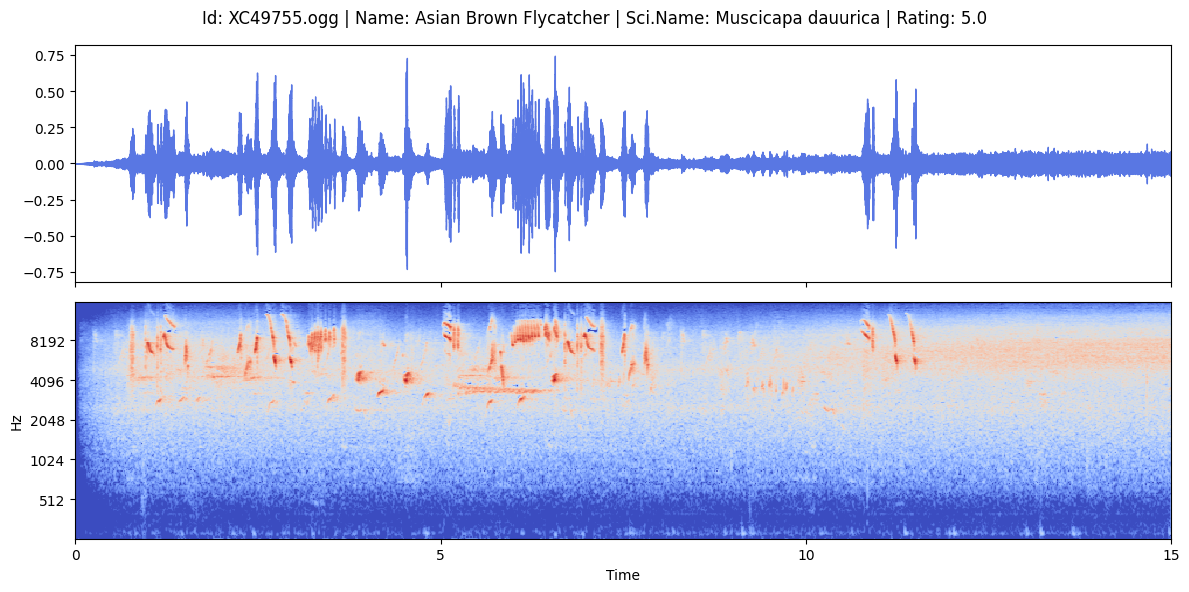

In [ ]:
row = df.iloc[35]

# Display audio
display_audio(row)

# Sample 2

# Audio:


# Visualization:


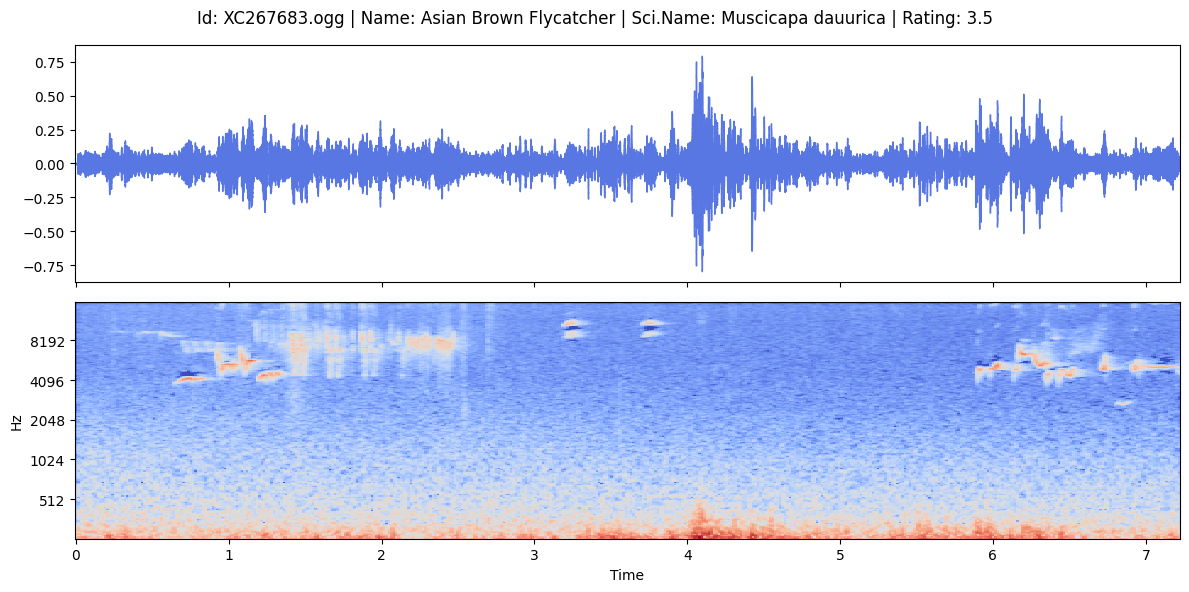

In [ ]:
row = df.iloc[10]

# Display audio
display_audio(row)

# Sample 3

# Audio:


# Visualization:


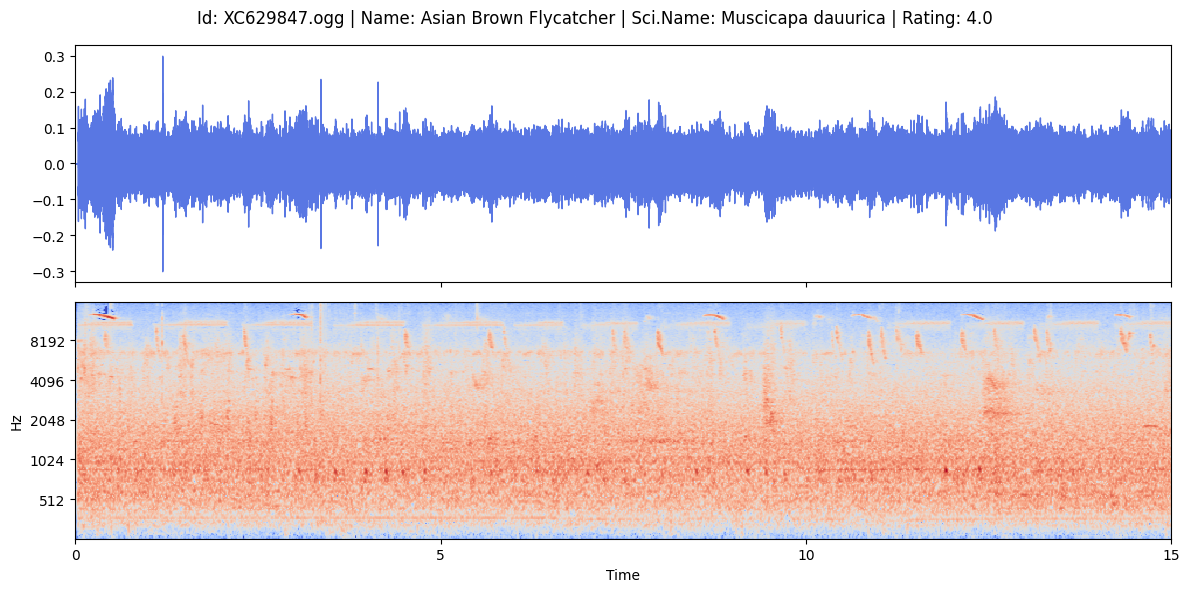

In [ ]:
row = df.iloc[52]

# Display audio
display_audio(row)

## Metadata Analysis and Visualization

In [ ]:
num_df = df.select_dtypes(include=['number'])
cat_df = df.select_dtypes(exclude=['number'])

In [ ]:
df.head(5)

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

      scientific_name             common_name  \
0  Muscicapa dauurica  Asian Brown Flycatcher   
1  Muscicapa dauurica  Asian Brown Flycatcher   
2  Muscicapa dauurica  Asian Brown Flycatcher   
3  Muscicapa dauurica  Asian Brown Flycatcher   
4  Muscicapa dauurica  Asian Brown Flycatcher   

                              author  \
0                     Matt Slaymaker   
1                   Magnus Hellström   
2                      Stuart Fisher   
3                          vir joshi   
4  Albert Lastukhin & Sergei Karpeev   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   
2  Creative Commons Attribution-NonCommercial-Sha...     2.5   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                 url      filename  \
0  https://www.xeno-canto.org/134896  XC134896.ogg   
1  https://www.xeno-canto.org/164848  XC164848.ogg   
2  https://www.xeno-canto.org/175797  XC175797.ogg   
3  https://www.xeno-canto.org/207738  XC207738.ogg   
4  https://www.xeno-canto.org/209218  XC209218.ogg   

                                            filepath  target     xc_id  
0  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC134896  
1  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC164848  
2  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC175797  
3  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC207738  
4  /kaggle/input/birdclef-2024/train_audio/asbfly...       0  XC209218

#### Descriptive Statistics

In [ ]:
num_df.describe().T

count       mean        std       min      25%      50%  \
latitude   24081.0  32.537040  19.440382  -43.5240  17.1601  37.1551   
longitude  24081.0  43.640699  50.191352 -171.7654   2.5457  26.6876   
rating     24459.0   3.843493   1.100840    0.0000   3.0000   4.0000   
target     24459.0  79.652398  51.163060    0.0000  40.0000  71.0000   

                75%       max  
latitude    49.1144   71.9640  
longitude   85.3193  177.4478  
rating       5.0000    5.0000  
target     120.0000  181.0000

#### Univariate Analysis

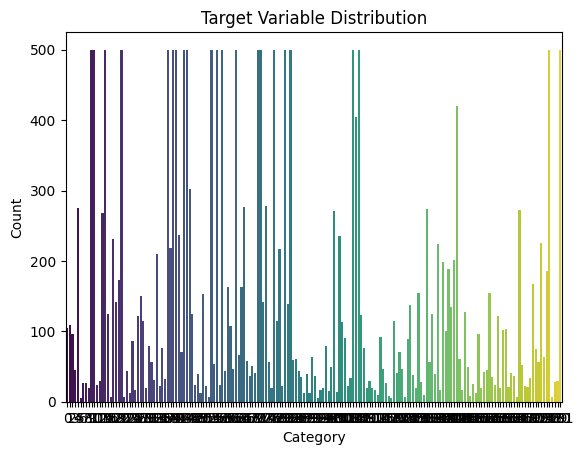

In [ ]:
sns.countplot(data=df, x='target', palette='viridis')
plt.title('Target Variable Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

The classes are unequally distributed as can be seen from the distribution above

# Data Split

The training data is being split into a train and a validation data using target stratification

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Training dataset size: {len(train_df)} | Validation dataset size: {len(valid_df)}")

Training dataset size: 19567 | Validation dataset size: 4892


# Data Pipeline

A python function is defined for handling the complete pipeline of the data flow. It employs tensorflow.data.Dataset for processing of Data

In [ ]:
def build_dataset(paths, labels=None, batch_size=32,
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Dataloaders

In [ ]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

Tensor("strided_slice_1:0", shape=(), dtype=int32)
Tensor("strided_slice_1:0", shape=(), dtype=int32)


## Visualizations

In [ ]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]),
                     n_fft=CFG.nfft,
                     hop_length=CFG.hop_length,
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

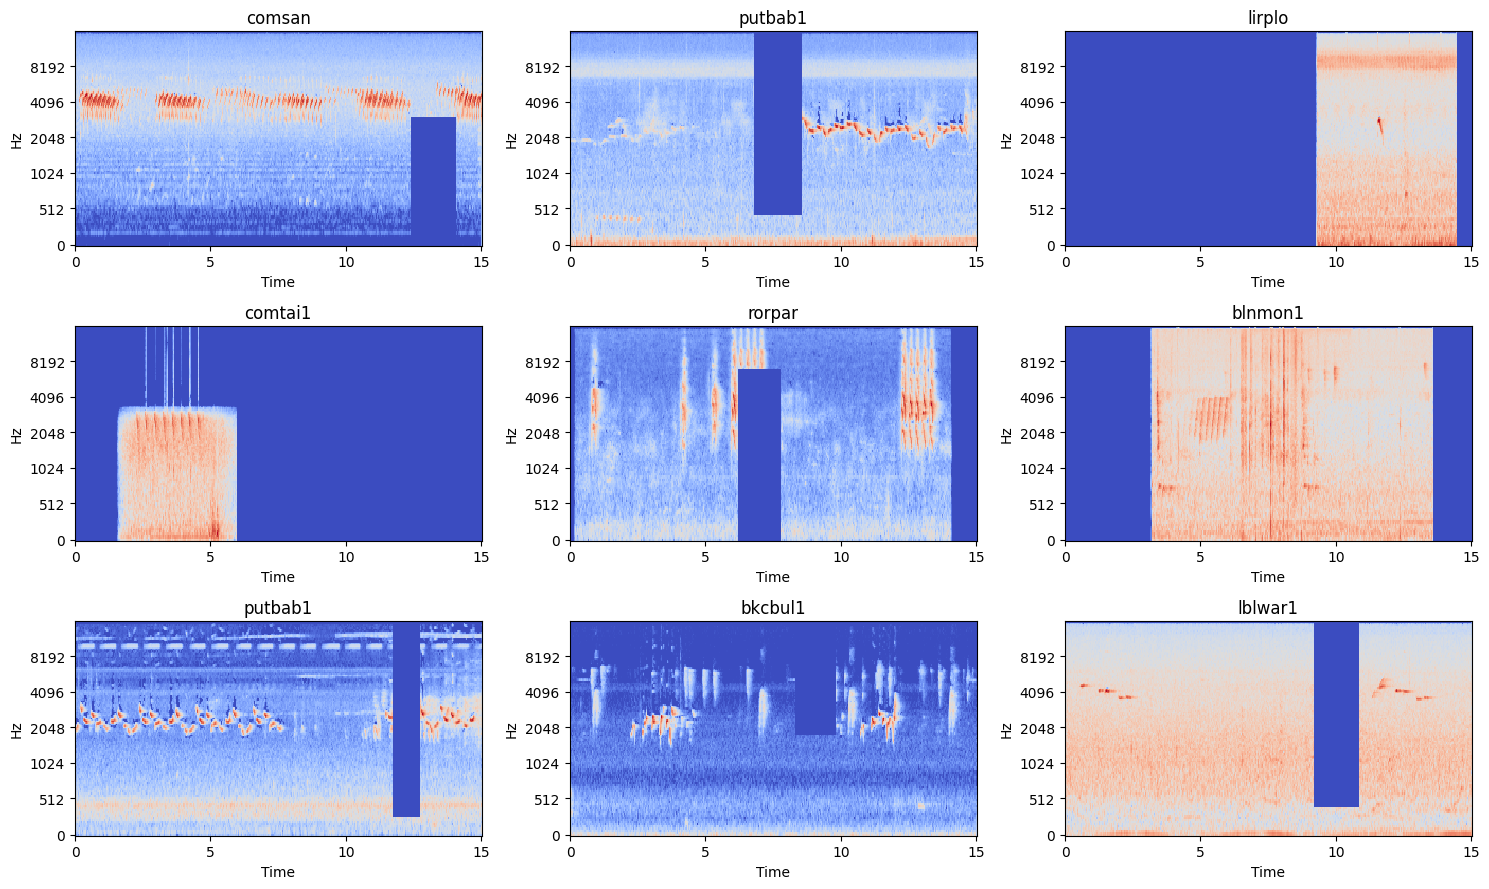

In [ ]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)

## Loading Trained Weights

In [ ]:
inp = keras.layers.Input(shape=(None, None, 3))
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=CFG.num_classes,
    name="classifier"
)(inp)
model = keras.models.Model(inputs=inp, outputs=out)
model.load_weights("/kaggle/input/birdclef24-kerascv-starter-train/best_model.weights.h5")

# Modeling

In [ ]:
#Input layer:
inp = keras.layers.Input(shape=(None, None, 3))
#Pretrained backbone:
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)

#Output layer:
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=CFG.num_classes,
    name="classifier"
)(inp)

#Building model:
model = keras.models.Model(inputs=inp, outputs=out)

#Compiling model with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ImageClassifier)    │ (None, 182)            │     9,025,812 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,025,812 (34.43 MB)

 Trainable params: 8,943,524 (34.12 MB)

 Non-trainable params: 82,288 (321.44 KB)

# Learning Rate Scheduler

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

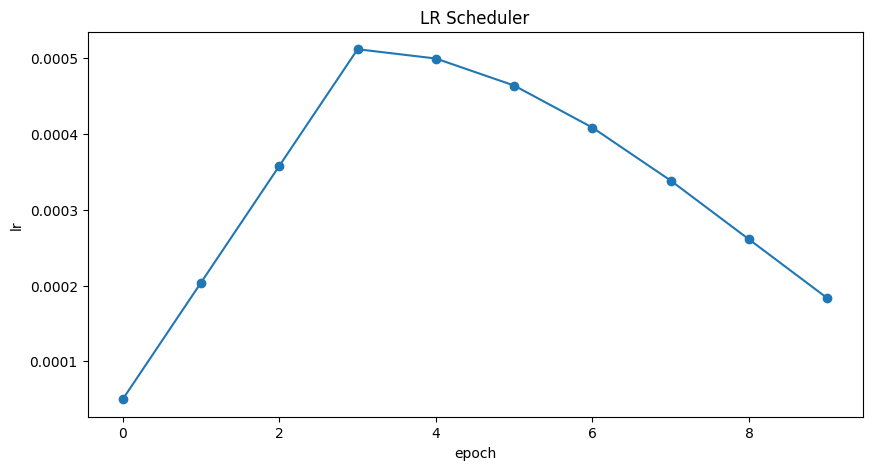

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

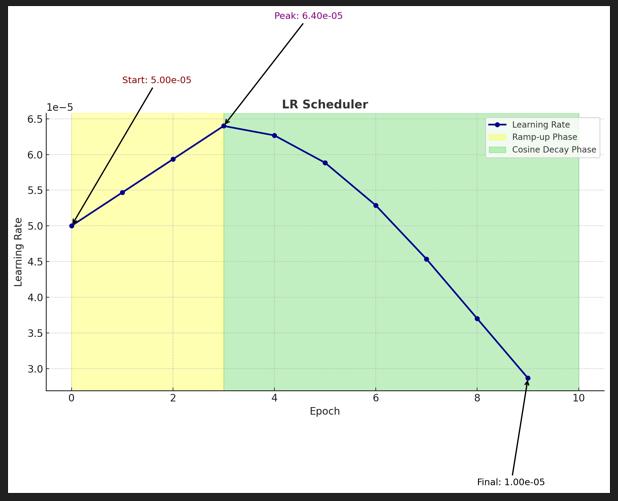

# Model Checkpoint

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

# Training

In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    verbose=1
)

Epoch 1/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 2595s 8s/step - auc: 0.6355 - loss: 5.0050 - val_auc: 0.7667 - val_loss: 4.6228 - learning_rate: 5.0000e-05
Epoch 2/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - auc: 0.7957 - loss: 4.2979 - val_auc: 0.9231 - val_loss: 2.7503 - learning_rate: 2.0400e-04
Epoch 3/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 67s 217ms/step - auc: 0.8528 - loss: 2.7378 - val_auc: 0.9552 - val_loss: 1.9115 - learning_rate: 3.5800e-04
Epoch 4/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 67s 217ms/step - auc: 0.8698 - loss: 2.0222 - val_auc: 0.9586 - val_loss: 1.6972 - learning_rate: 5.1200e-04
Epoch 5/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 67s 217ms/step - auc: 0.8803 - loss: 1.6113 - val_auc: 0.9616 - val_loss: 1.5593 - learning_rate: 4.9972e-04
Epoch 6/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 67s 217ms/step - auc: 0.8877 - loss: 1.3231 - val_auc: 0.9627 - val_loss: 1.5132 - learning_rate: 4.6406e-04
Epoch 7/8
305/305 ━━━━━━━━━━━━━━━━━━━━ 66s 213ms/step - auc: 0.8934 - loss: 1.1091 - val_auc: 0.9607 - val_loss: 

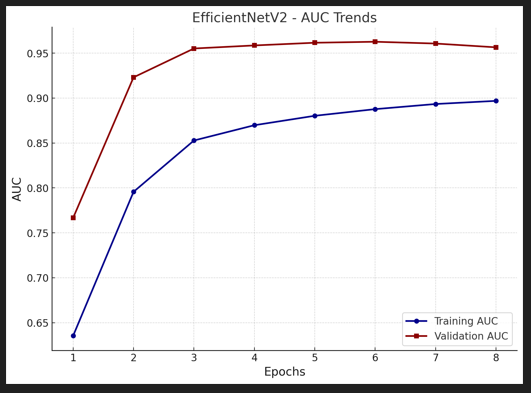

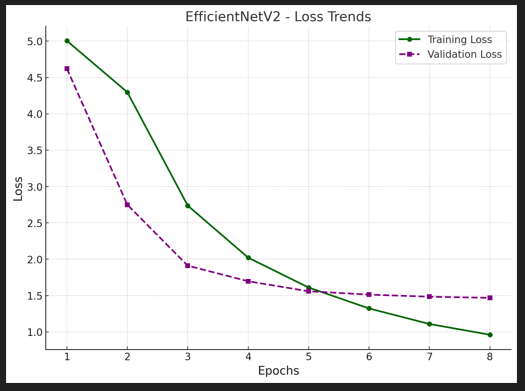

# Result Summary

In [ ]:
best_epoch = np.argmax(history.history["val_auc"])
best_score = history.history["val_auc"][best_epoch]
print('>>> Best AUC: ', best_score)
print('>>> Best Epoch: ', best_epoch+1)

>>> Best AUC:  0.9627299904823303
>>> Best Epoch:  6
